# Actividad

In [5]:
# Calculo de V0, PnL, rendimiento y VaR
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = "datos_historicos.csv"
df = pd.read_csv(data_path, parse_dates=["Date"])

# Ordena por fecha ascendente para que la diferencia refleje V0_hoy - V0_ayer
df = df.sort_values("Date").reset_index(drop=True)

shares = {
    "NVDA.O": 592,
    "MSFT.O": 200,
    "SIEGn.DE": 369,
    "VLO": 639,
    "BA": 432,
    "JPM": 341,
    "LMT": 217,
    "FEIM.OQ": 1544,
    "GOOGL.O": 223,
    "INTC.O": 1436,
    "MU.O": 163,
    "XAU= (BID)": 9,
}

# Calcula el valor diario del portafolio (V0)
df["V0"] = sum(df[col] * qty for col, qty in shares.items())

# Calcula PnL y rendimiento diario
df["PnL"] = df["V0"].diff()
df["rendimiento"] = df["V0"].pct_change()

# PnL ordenado de menor a mayor (DataFrame auxiliar)
pnl_ranked = (
    df[["Date", "PnL"]]
    .dropna()
    .sort_values("PnL")
    .reset_index(drop=True)
    .rename(columns={"PnL": "PnL_ordenado"})
)

df.tail()

,Date,Día,NVDA.O,MSFT.O,SIEGn.DE,VLO,BA,JPM,LMT,FEIM.OQ,GOOGL.O,INTC.O,MU.O,XAU= (BID),V0,PnL,rendimiento
995,2025-10-29,5,207.04,541.55,245.75,170.66,213.58,305.51,485.33,37.15,274.57,41.34,226.63,3929.3633,982631.1597,1072.6556,0.001093
996,2025-10-30,4,202.89,525.76,247.00,170.10,200.08,309.44,489.72,37.42,281.48,40.16,224.01,4023.2200,974261.5100,-8369.6497,-0.008518
997,2025-10-31,3,202.49,517.81,245.55,169.56,201.02,311.12,491.88,36.72,281.19,39.99,223.77,4001.7798,971380.6082,-2880.9018,-0.002957
998,2025-11-03,2,206.88,517.03,247.20,171.60,204.55,309.35,487.94,35.70,283.72,39.50,234.70,4001.4200,975866.3300,4485.7218,0.004618
999,2025-11-04,1,198.69,514.33,244.20,169.11,198.05,309.25,484.98,33.97,277.54,37.03,218.03,3931.7800,953355.1700,-22511.1600,-0.023068


In [6]:
# Estadisticas de rendimiento y calculo de VaR
rend_series = df["rendimiento"].dropna()
rend_promedio = rend_series.mean()
rend_desv = rend_series.std()

v0_actual = df["V0"].iloc[-1]

z_1pct = 2.326
z_5pct = 1.645

var_param_1pct = v0_actual * (z_1pct * rend_promedio - rend_desv)
var_param_5pct = v0_actual * (z_5pct * rend_promedio - rend_desv)

pnl_hist = df["PnL"].dropna()
var_hist_1pct = abs(pnl_hist.quantile(0.01, interpolation="lower"))
var_hist_5pct = abs(pnl_hist.quantile(0.05, interpolation="lower"))

resumen_metricas = pd.DataFrame(
    {
        "metrica": [
            "rendimiento_promedio",
            "rendimiento_desviacion",
            "VaR_parametrico_1pct",
            "VaR_parametrico_5pct",
            "VaR_no_parametrico_1pct",
            "VaR_no_parametrico_5pct",
        ],
        "valor": [
            rend_promedio,
            rend_desv,
            var_param_1pct,
            var_param_5pct,
            var_hist_1pct,
            var_hist_5pct,
        ],
    }
)

resumen_metricas

,metrica,valor
0,rendimiento_promedio,0.000724
1,rendimiento_desviacion,0.019478
2,VaR_parametrico_1pct,-16962.855811
3,VaR_parametrico_5pct,-17433.212849
4,VaR_no_parametrico_1pct,49775.352600
5,VaR_no_parametrico_5pct,12023.310000


In [7]:
# Vista del PnL ordenado (los 10 valores mas bajos)
pnl_ranked.head(10)

,Date,PnL_ordenado
0,2025-04-21,-79068.4275
1,2024-12-31,-69646.2320
2,2025-05-01,-68121.9534
3,2024-05-01,-67635.5338
4,2024-12-24,-64235.7400
5,2024-04-01,-63148.7000
6,2021-12-31,-57285.1854
7,2023-05-01,-54810.2498
8,2023-12-26,-54419.8909
9,2023-04-10,-49775.3526


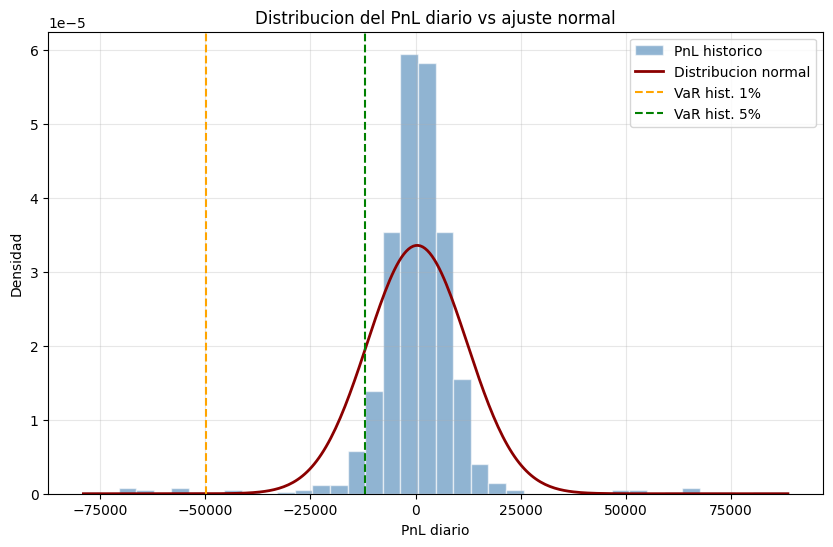

In [8]:
# Histograma del PnL con distribucion normal ajustada
pnl_values = df["PnL"].dropna()
mu_pnl = pnl_values.mean()
std_pnl = pnl_values.std()

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(pnl_values, bins=40, density=True, alpha=0.6, color="steelblue", edgecolor="white", label="PnL historico")

x_vals = np.linspace(pnl_values.min(), pnl_values.max(), 300)
normal_pdf = (1 / (std_pnl * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_vals - mu_pnl) / std_pnl) ** 2)
ax.plot(x_vals, normal_pdf, color="darkred", linewidth=2, label="Distribucion normal")

ax.axvline(-var_hist_1pct, color="orange", linestyle="--", linewidth=1.5, label="VaR hist. 1%")
ax.axvline(-var_hist_5pct, color="green", linestyle="--", linewidth=1.5, label="VaR hist. 5%")

ax.set_title("Distribucion del PnL diario vs ajuste normal")
ax.set_xlabel("PnL diario")
ax.set_ylabel("Densidad")
ax.legend()
ax.grid(alpha=0.3)

plt.show()

Al ejecutar el histograma, la cola izquierda del PnL historico cae con mayor densidad que la curva normal ajustada, lo que sugiere que las perdidas extremas ocurren con mayor frecuencia que lo previsto por la aproximacion gaussiana. Las metricas de VaR muestran el umbral de perdida maxima esperado para un dia: el VaR parametrico al 1% (`var_param_1pct`) limita las perdidas bajo el supuesto de normalidad con 99% de confianza, mientras que el VaR historico al 1% (`var_hist_1pct`) corresponde a la peor perdida observada dentro del 1% de dias mas adversos y no depende de supuestos de distribucion.